
Dataset directory structure:
Directory: horse-or-human/validation
Number of images: 0
Directory: horse-or-human/train
Number of images: 0
Directory: horse-or-human/validation/humans
Number of images: 128
Directory: horse-or-human/validation/horses
Number of images: 128
Directory: horse-or-human/train/humans
Number of images: 527
Directory: horse-or-human/train/horses
Number of images: 500

Dataset composition:
Horses: 500 images (48.7%)
Humans: 527 images (51.3%)
Found 822 images belonging to 2 classes.
Found 205 images belonging to 2 classes.
Found 256 images belonging to 2 classes.

Class weights:
Horses: 0.82
Humans: 0.78


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


49/52 ━━━━━━━━━━━━━━━━━━━━ 1s 409ms/step - accuracy: 0.7318 - auc: 0.7973 - loss: 2.9988 - precision: 0.7448 - recall: 0.7153
Epoch 1: val_loss improved from inf to 3.06087, saving model to best_model.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 42s 543ms/step - accuracy: 0.7388 - auc: 0.8049 - loss: 2.9941 - precision: 0.7527 - recall: 0.7217 - val_accuracy: 0.5122 - val_auc: 0.8333 - val_loss: 3.0609 - val_precision: 0.5122 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/50
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.8936 - auc: 0.9681 - loss: 2.2810 - precision: 0.9262 - recall: 0.8712
Epoch 2: val_loss improved from 3.06087 to 2.13626, saving model to best_model.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 23s 393ms/step - accuracy: 0.8946 - auc: 0.9685 - loss: 2.2679 - precision: 0.9262 - recall: 0.8727 - val_accuracy: 0.7317 - val_auc: 0.8805 - val_loss: 2.1363 - val_precision: 0.6582 - val_recall: 0.9905 - learning_rate: 0.0010
Epoch 3/50
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accur

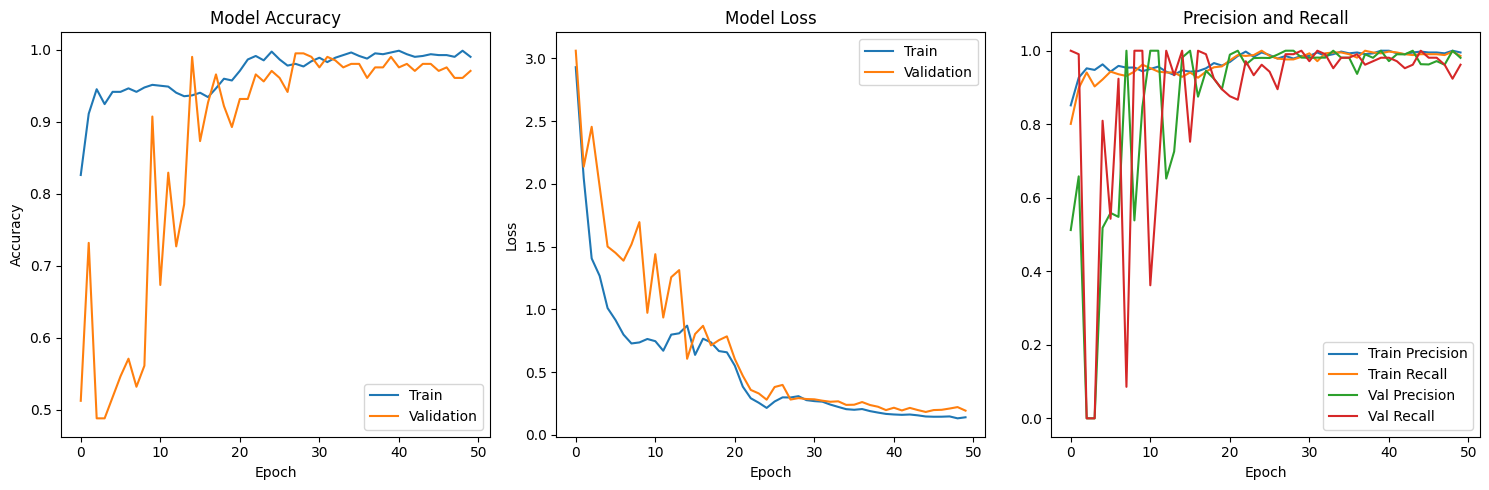

In [1]:
# This gives fantastic accuracy on training and validation
# But, the results are actually really bad!!!

'''
Note:
The numbers will look perfect - almost too perfect. And that's our first clue.
In machine learning, when we see perfect validation scores, we should always
pause to investigate further.
The reason for this apparent discrepancy lies in how the validation data is
being handled. In your training code, the validation split is coming from
the same training directory (using ImageDataGenerator's validation_split
parameter). This means your validation set is very similar to your training
data - it's seeing variations of the same kinds of images it trained on.
However, when we later tested the model on completely separate horse images
(from the test set), it performed poorly. This tells us that while the model
learned to recognize the specific characteristics of horses in the
training/validation data perfectly, it didn't learn generalizable features
that would help it recognize horses in new, unseen situations.
Think of it like studying for a test: if you practice with one set of
questions and then get variations of the same questions on the test, you
might score perfectly. But if the test contains completely new questions
that test the same concepts in different ways, you might struggle. This is
essentially what happened with our model - it "memorized" the training data
perfectly but didn't learn the broader concept of what makes a horse look
like a horse.
'''
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import requests
import zipfile
import pathlib

def download_and_prepare_dataset():
    """
    Downloads and extracts the horses or humans dataset.
    Creates separate training and validation directories if needed.
    """
    # URLs for the dataset zip files
    train_url = "https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip"
    validation_url = "https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip"

    # Create base directory
    base_dir = pathlib.Path('horse-or-human')
    base_dir.mkdir(exist_ok=True)

    def download_and_extract(url, target_dir):
        # Download the zip file
        response = requests.get(url)
        zip_path = base_dir / "temp.zip"
        zip_path.write_bytes(response.content)

        # Extract the zip file
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(target_dir)

        # Remove the temporary zip file
        zip_path.unlink()

    # Download and extract training data
    print("Downloading training dataset...")
    train_dir = base_dir / 'train'
    download_and_extract(train_url, train_dir)

    # Download and extract validation data
    print("Downloading validation dataset...")
    validation_dir = base_dir / 'validation'
    download_and_extract(validation_url, validation_dir)

    # Verify the directory structure
    print("\nDataset directory structure:")
    for item in base_dir.glob('**/*'):
        if item.is_dir():
            print(f"Directory: {item}")
            print(f"Number of images: {len(list(item.glob('*.png')))}")

    return train_dir, validation_dir

class DatasetAnalyzer:
    """
    Analyzes characteristics and potential biases in the horses-humans dataset
    """
    def __init__(self, data_dir):
        self.data_dir = data_dir

    def analyze_class_distribution(self):
        """
        Examines the distribution of images between horses and humans
        """
        horses_path = self.data_dir / 'horses'
        humans_path = self.data_dir / 'humans'

        horses_count = len(list(horses_path.glob('*.png')))
        humans_count = len(list(humans_path.glob('*.png')))

        print(f"\nDataset composition:")
        print(f"Horses: {horses_count} images ({horses_count/(horses_count+humans_count)*100:.1f}%)")
        print(f"Humans: {humans_count} images ({humans_count/(horses_count+humans_count)*100:.1f}%)")

        return horses_count, humans_count

    def analyze_image_characteristics(self):
        """
        Analyzes image sizes, color distributions, and brightness levels
        to identify potential technical biases
        """
        characteristics = {
            'horses': {'sizes': [], 'brightness': []},
            'humans': {'sizes': [], 'brightness': []}
        }

        for category in ['horses', 'humans']:
            path = self.data_dir / category
            for img_path in path.glob('*.png'):
                img = tf.keras.preprocessing.image.load_img(img_path)
                img_array = tf.keras.preprocessing.image.img_to_array(img)

                # Record image size
                characteristics[category]['sizes'].append(img_array.shape)

                # Calculate average brightness
                brightness = np.mean(img_array)
                characteristics[category]['brightness'].append(brightness)

        return characteristics


def create_improved_model():
    """
    Creates a simpler, more robust model architecture.
    Key changes:
    1. Reduced model complexity to prevent overfitting
    2. Added L2 regularization
    3. Adjusted dropout rates
    4. Simplified structure
    """
    regularizer = tf.keras.regularizers.l2(0.01)

    model = models.Sequential([
        # First block - keep simple
        layers.Conv2D(16, (3, 3), activation='relu',
                     kernel_regularizer=regularizer,
                     input_shape=(300, 300, 3)),
        layers.MaxPooling2D(2, 2),
        layers.BatchNormalization(),

        # Second block
        layers.Conv2D(32, (3, 3), activation='relu',
                     kernel_regularizer=regularizer),
        layers.MaxPooling2D(2, 2),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        # Third block
        layers.Conv2D(64, (3, 3), activation='relu',
                     kernel_regularizer=regularizer),
        layers.MaxPooling2D(2, 2),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        # Dense layers
        layers.Flatten(),
        layers.Dense(64, activation='relu',
                    kernel_regularizer=regularizer),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    # Use a larger learning rate initially
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(name='auc')]  # Added AUC metric
    )

    return model

def create_balanced_generators(train_dir, validation_dir):
    """
    Creates data generators with more careful augmentation
    """
    # Training generator with measured augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,  # Reduced from 40
        width_shift_range=0.1,  # Reduced from 0.2
        height_shift_range=0.1,  # Reduced from 0.2
        shear_range=0.1,  # Reduced from 0.2
        zoom_range=0.1,  # Reduced from 0.2
        horizontal_flip=True,
        validation_split=0.2  # Added validation split
    )

    # Create training generator
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(300, 300),
        batch_size=16,  # Reduced batch size
        class_mode='binary',
        subset='training',
        shuffle=True
    )

    # Create validation generator from training data
    validation_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(300, 300),
        batch_size=16,
        class_mode='binary',
        subset='validation',
        shuffle=True
    )

    # Create test generator
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(300, 300),
        batch_size=16,
        class_mode='binary',
        shuffle=False
    )

    return train_generator, validation_generator, test_generator

def train_model(model, train_generator, validation_generator, class_weights):
    """
    Trains the model with improved monitoring and callbacks
    """
    callbacks = [
        # Monitor validation loss with increased patience
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        # More gradual learning rate reduction
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,  # More gentle reduction
            patience=5,
            min_lr=1e-6,
            verbose=1
        ),
        # Save best model
        tf.keras.callbacks.ModelCheckpoint(
            'best_model.keras',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ]

    history = model.fit(
        train_generator,
        epochs=50,  # Increased epochs
        validation_data=validation_generator,
        class_weight=class_weights,
        callbacks=callbacks
    )

    return history

def main():
    # Download and prepare the dataset
    train_dir, validation_dir = download_and_prepare_dataset()

    # Analyze dataset
    analyzer = DatasetAnalyzer(train_dir)
    class_distribution = analyzer.analyze_class_distribution()
    image_characteristics = analyzer.analyze_image_characteristics()

    # Create generators
    train_generator, validation_generator, test_generator = create_balanced_generators(
        train_dir, validation_dir)

    # Calculate class weights
    total_train = train_generator.samples
    n_horses = len(list(train_dir.glob('horses/*.png')))
    n_humans = len(list(train_dir.glob('humans/*.png')))

    class_weights = {
        0: total_train / (2.0 * n_horses),
        1: total_train / (2.0 * n_humans)
    }

    print(f"\nClass weights:")
    print(f"Horses: {class_weights[0]:.2f}")
    print(f"Humans: {class_weights[1]:.2f}")

    # Create and train model
    model = create_improved_model()
    history = train_model(model, train_generator, validation_generator, class_weights)

    # Evaluate on test set
    print("\nEvaluating on test set...")
    test_results = model.evaluate(test_generator, verbose=1)
    metrics = dict(zip(model.metrics_names, test_results))

    print("\nFinal Test Performance:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.3f}")

    # Plot training history
    plt.figure(figsize=(15, 5))

    # Plot accuracy
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])

    # Plot loss
    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])

    # Plot precision/recall
    plt.subplot(1, 3, 3)
    plt.plot(history.history['precision'])
    plt.plot(history.history['recall'])
    plt.plot(history.history['val_precision'])
    plt.plot(history.history['val_recall'])
    plt.title('Precision and Recall')
    plt.xlabel('Epoch')
    plt.legend(['Train Precision', 'Train Recall',
               'Val Precision', 'Val Recall'])

    plt.tight_layout()
    plt.show()

    return model, history, metrics

if __name__ == "__main__":
    model, history, metrics = main()

In [2]:
# Post training analysis
# Note that while the validation scores on 2 looked excellent -- there are huge problems with horses that are hidden in the results
# Running these scripts will demonstrate that
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def analyze_model_performance(model_path, validation_dir):
    """
    Performs a detailed analysis of a trained model's performance on the validation dataset.
    Uses correct counting methods for binary classification metrics.
    """
    # Load the trained model
    model = tf.keras.models.load_model(model_path)

    # Create the validation generator
    validation_datagen = ImageDataGenerator(rescale=1./255)
    validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(300, 300),
        batch_size=32,
        class_mode='binary',
        shuffle=False
    )

    # Get predictions
    predictions_raw = model.predict(validation_generator)
    predictions = (predictions_raw > 0.5).astype(int)
    true_classes = validation_generator.classes

    # Calculate confusion matrix first
    cm = confusion_matrix(true_classes, predictions)

    print("\nDetailed Performance Analysis")
    print("=" * 50)

    # Calculate metrics for each class using confusion matrix values
    for class_idx, class_name in enumerate(['horses', 'humans']):
        if class_idx == 0:  # Horses
            TP = cm[0, 0]  # True Positives for horses
            FP = cm[1, 0]  # False Positives (humans predicted as horses)
            FN = cm[0, 1]  # False Negatives (horses predicted as humans)
            TN = cm[1, 1]  # True Negatives (humans correctly identified)
        else:  # Humans
            TP = cm[1, 1]  # True Positives for humans
            FP = cm[0, 1]  # False Positives (horses predicted as humans)
            FN = cm[1, 0]  # False Negatives (humans predicted as horses)
            TN = cm[0, 0]  # True Negatives (horses correctly identified)

        # Calculate metrics
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = (TP + TN) / (TP + TN + FP + FN)
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

        print(f"\nMetrics for {class_name.capitalize()}:")
        print("-" * 40)
        print(f"Precision:   {precision:.3f} (When we predict {class_name}, how often are we right?)")
        print(f"Recall:      {recall:.3f} (What fraction of actual {class_name} do we find?)")
        print(f"F1-Score:    {f1_score:.3f} (Harmonic mean of precision and recall)")
        print(f"Accuracy:    {accuracy:.3f} (Overall correct predictions for this class)")
        print(f"Specificity: {specificity:.3f} (How well we identify non-{class_name})")

        print(f"\nDetailed Counts:")
        print(f"True Positives:  {TP} (Correct {class_name} predictions)")
        print(f"False Positives: {FP} (Incorrectly predicted as {class_name})")
        print(f"False Negatives: {FN} (Missed {class_name} predictions)")
        print(f"True Negatives:  {TN} (Correctly identified non-{class_name})")

    # Display confusion matrix
    print("\nConfusion Matrix:")
    print("=" * 50)
    print("                 Predicted Horses    Predicted Humans")
    print(f"Actual Horses        {cm[0,0]:<18d}{cm[0,1]}")
    print(f"Actual Humans        {cm[1,0]:<18d}{cm[1,1]}")

    # Overall model performance
    overall_results = model.evaluate(validation_generator, verbose=0)
    metrics_names = model.metrics_names

    print("\nOverall Model Performance:")
    print("=" * 50)
    for name, value in zip(metrics_names, overall_results):
        print(f"{name}: {value:.3f}")

    # Generate classification report
    print("\nClassification Report:")
    print("=" * 50)
    print(classification_report(true_classes, predictions,
                              target_names=['Horses', 'Humans']))

    return {
        'confusion_matrix': cm,
        'predictions': predictions,
        'true_classes': true_classes,
        'overall_metrics': dict(zip(metrics_names, overall_results))
    }

if __name__ == "__main__":
    MODEL_PATH = 'best_model.keras'
    VALIDATION_DIR = 'horse-or-human/validation'

    results = analyze_model_performance(MODEL_PATH, VALIDATION_DIR)

Found 256 images belonging to 2 classes.
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step

Detailed Performance Analysis

Metrics for Horses:
----------------------------------------
Precision:   1.000 (When we predict horses, how often are we right?)
Recall:      0.312 (What fraction of actual horses do we find?)
F1-Score:    0.476 (Harmonic mean of precision and recall)
Accuracy:    0.656 (Overall correct predictions for this class)
Specificity: 1.000 (How well we identify non-horses)

Detailed Counts:
True Positives:  40 (Correct horses predictions)
False Positives: 0 (Incorrectly predicted as horses)
False Negatives: 88 (Missed horses predictions)
True Negatives:  128 (Correctly identified non-horses)

Metrics for Humans:
----------------------------------------
Precision:   0.593 (When we predict humans, how often are we right?)
Recall:      1.000 (What fraction of actual humans do we find?)
F1-Score:    0.744 (Harmonic mean of precision and recall)
Accuracy:    0.656 (Overall correct predi